In [296]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

import pandas as pd

import torch

from experimental_neural_nets import Conv_test, Road_data

from functions import *
from preprocessing import *


In [297]:

imgs, gt_imgs, test_imgs = getting_datasets()
print (len(imgs), len(gt_imgs), len(test_imgs))
print (test_imgs[0].shape)

imgs, gt_imgs = rotate_train_data(imgs, gt_imgs)
imgs, gt_imgs = flip_train_data(imgs, gt_imgs)


Loading X_train 100 images
Loading Y_train100 images
Loading X_test50 images
100 100 50
(608, 608, 3)
Number of images:  400
Number of groundtruth images:  400
Number of images after flipping:  1600
Number of groundtruth images after flipping:  1600


Image size = 400,400


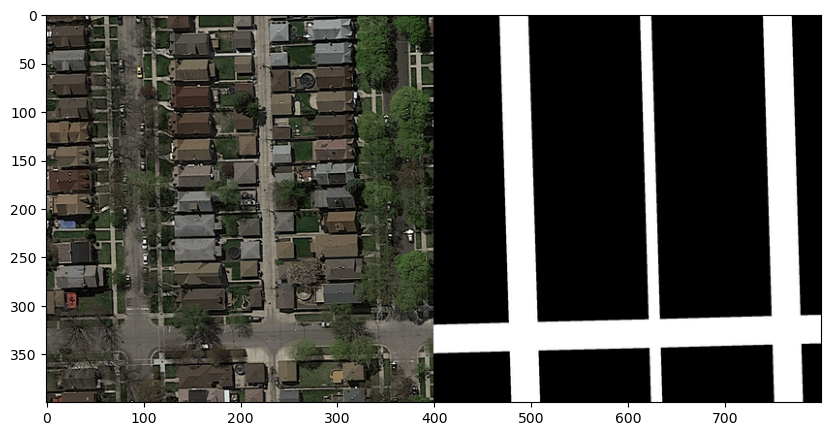

In [298]:
index=1000
print("Image size = " + str(imgs[index].shape[0]) + "," + str(imgs[index].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[index], gt_imgs[index])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [299]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels
n=len(imgs)
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
test_patches = [img_crop(test_imgs[i], patch_size, patch_size) for i in range(len(test_imgs))]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

test_patches = np.asarray(
    [
        test_patches[i][j]
        for i in range(len(test_patches))
        for j in range(len(test_patches[i]))
    ]
)

In [300]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat


# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat


# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

In [301]:
# Compute features for each image patch
foreground_threshold = (
    0.4  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0


X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
y_t  = np.asarray([extract_features(test_patches[i]) for i in range(len(test_patches))])

In [302]:
# Print feature statistics

print("Computed " + str(X.shape[0]) + " features")
print("Feature dimension = " + str(X.shape[1]))
print("Number of classes = " + str(np.max(Y)))  # TODO: fix, length(unique(Y))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print("Class 0: " + str(len(Y0)) + " samples")
print("Class 1: " + str(len(Y1)) + " samples")

Computed 1000000 features
Feature dimension = 6
Number of classes = 1
Class 0: 780976 samples
Class 1: 219024 samples


In [303]:
# Display a patch that belongs to the foreground class
#plt.imshow(gt_patches[Y1[3]], cmap="Greys_r")

In [304]:
# Plot 2d features using groundtruth to color the datapoints
#plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)

In [305]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced')

In [306]:
# Predict on the training set
print(X.shape)
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print("True positive rate = " + str(TPR))

(1000000, 6)
True positive rate = 0.15216


In [307]:
# Plot features using predictions to color datapoints
#plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors="k", cmap=plt.cm.Paired)

In [308]:
# Convert array of labels to an image


def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [309]:
# Run prediction on the img_idx-th image
img_idx = 0
image_dir =  "data/training/images/"
files = os.listdir(image_dir)
Xi = extract_img_features(image_dir + files[img_idx])
print(Xi.shape)
Zi = logreg.predict(Xi)
#plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors="k", cmap=plt.cm.Paired)

(625, 6)


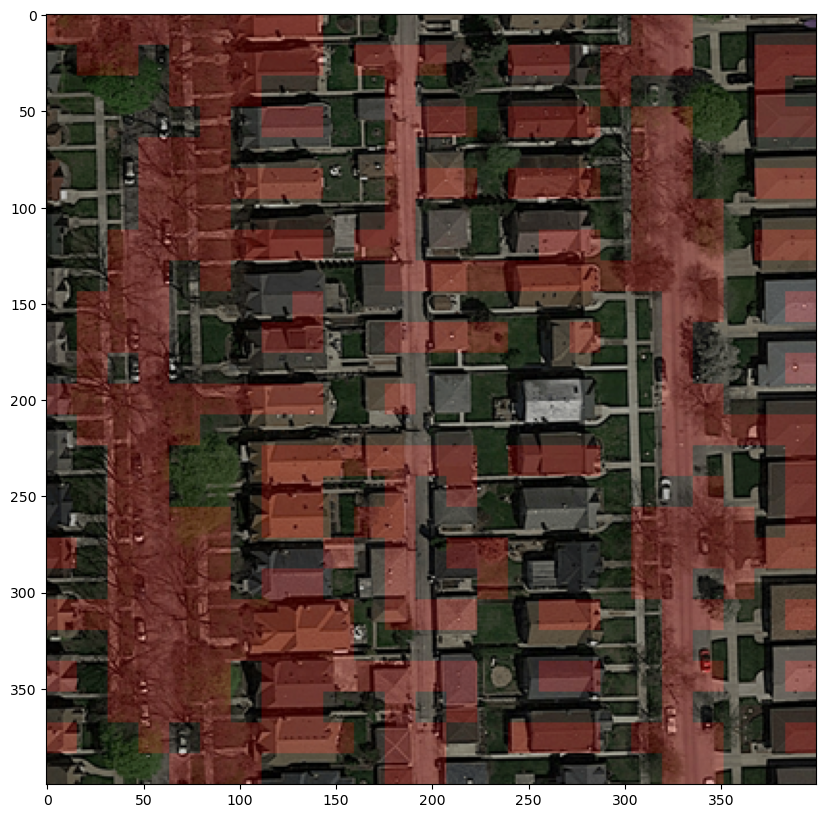

In [310]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]

predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size
plt.imshow(cimg, cmap="Greys_r")

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

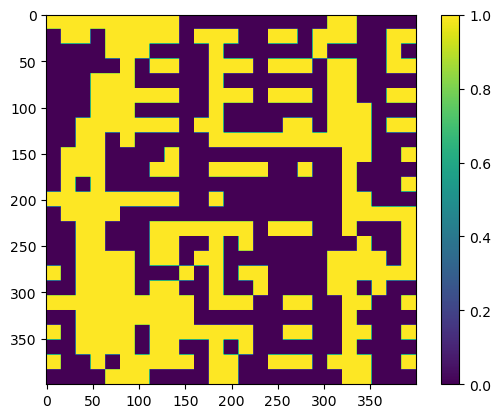

In [311]:
plt.imshow(predicted_im)
plt.colorbar()

(608, 608, 3)


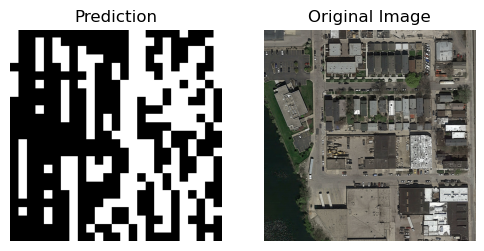

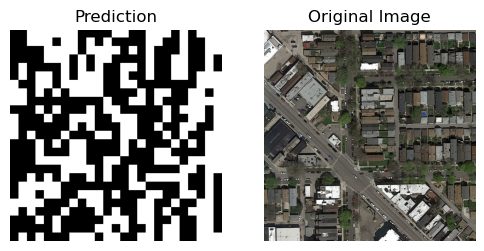

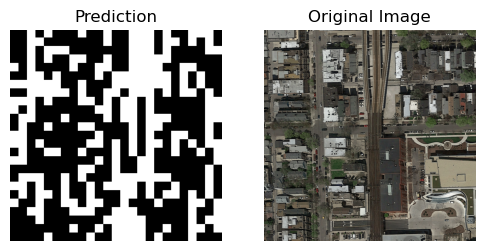

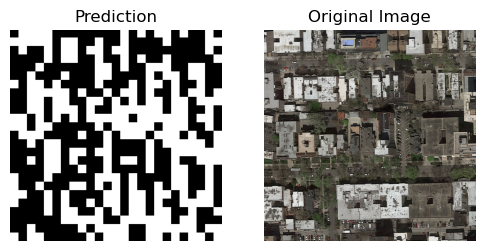

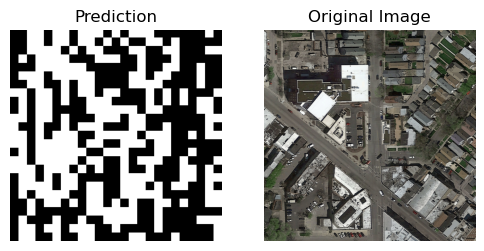

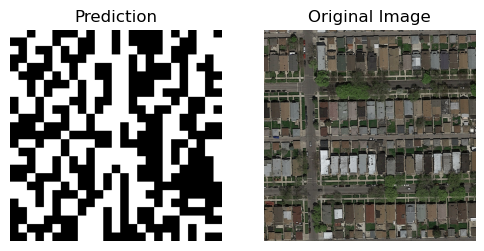

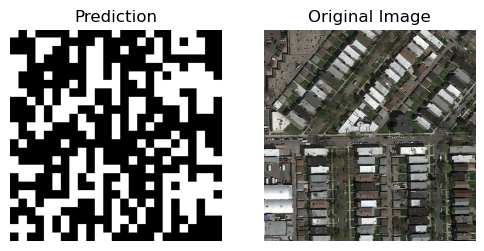

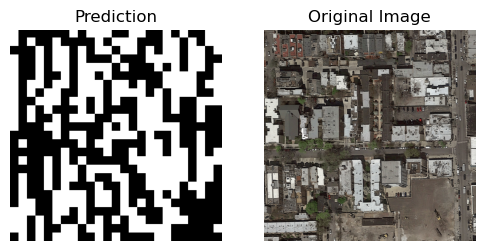

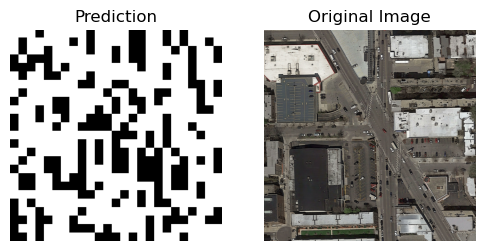

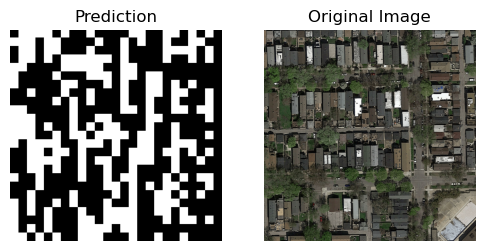

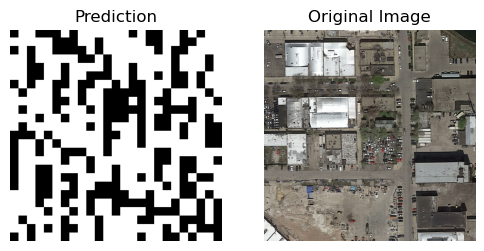

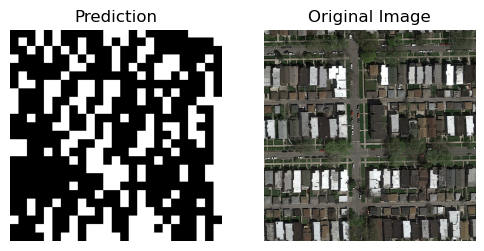

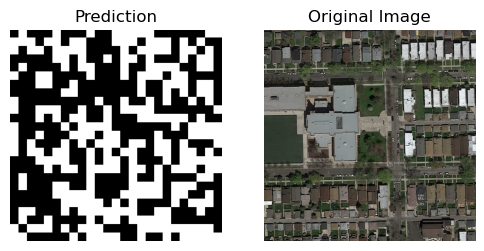

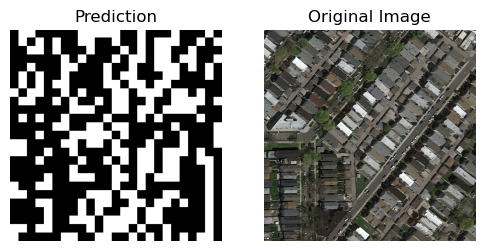

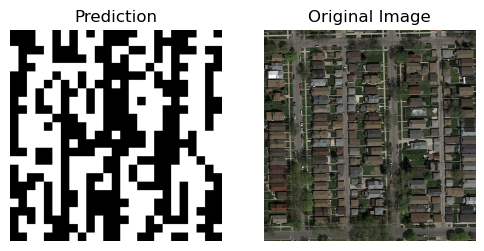

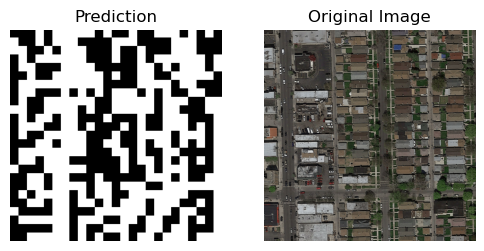

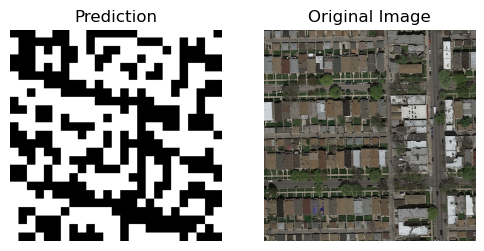

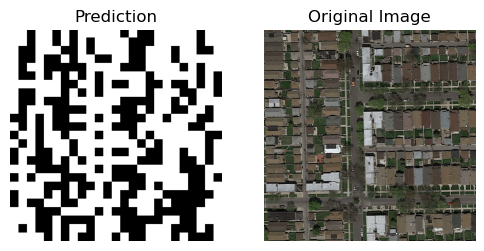

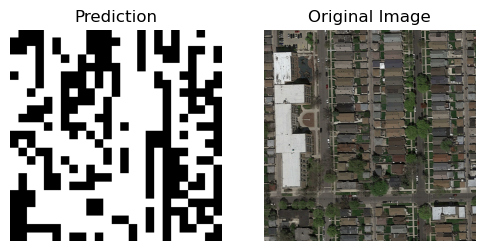

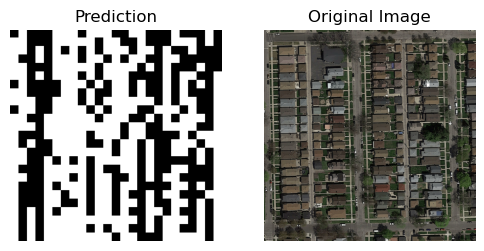

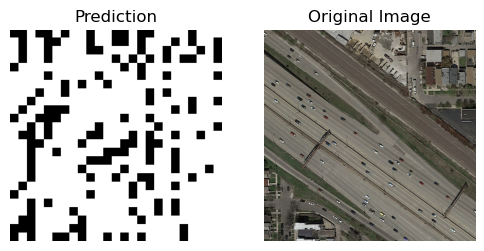

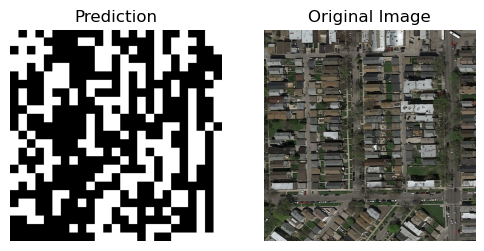

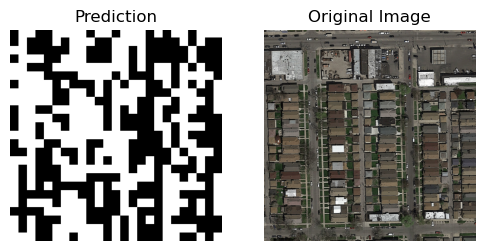

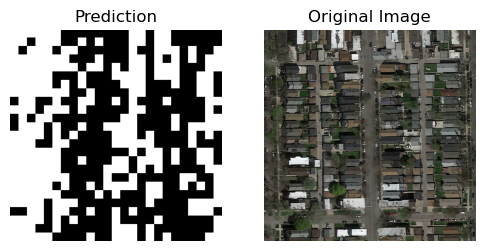

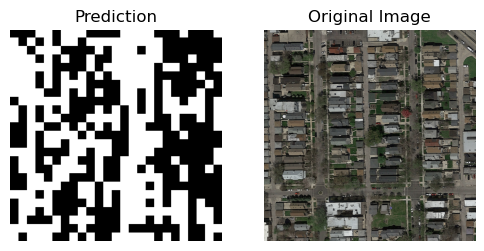

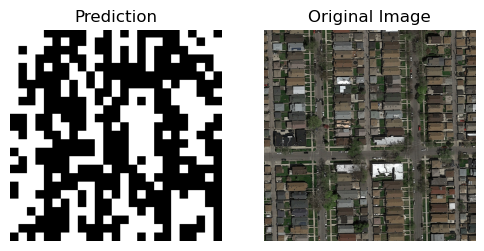

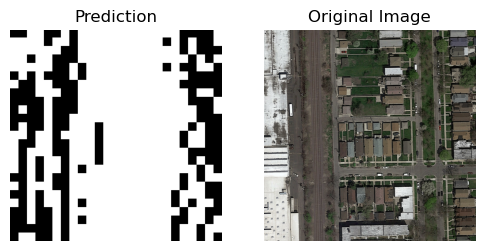

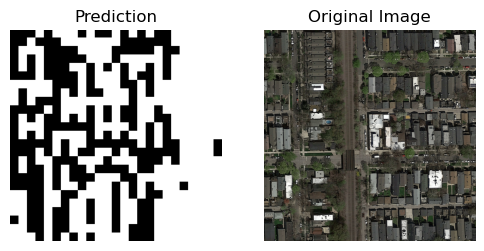

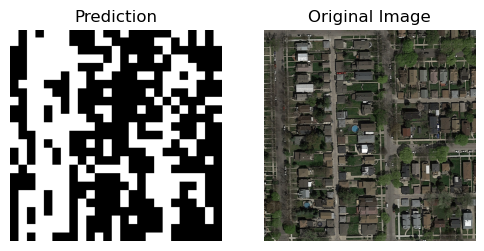

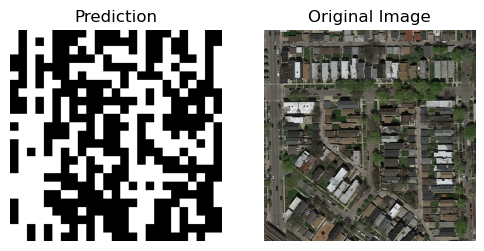

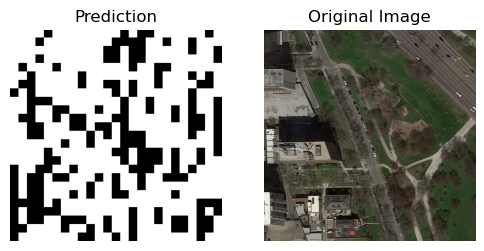

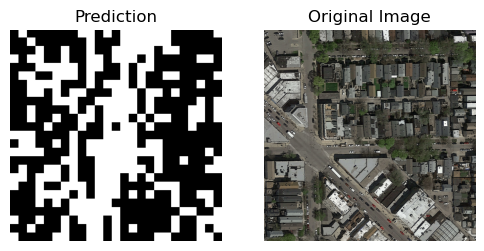

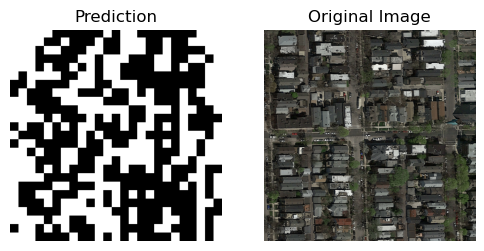

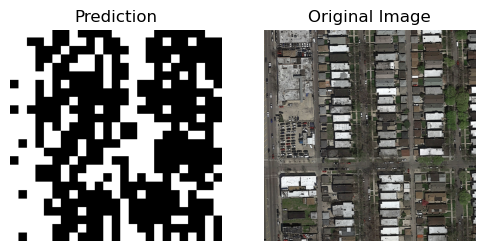

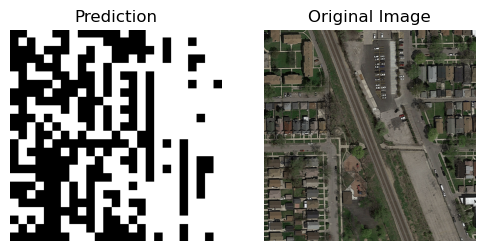

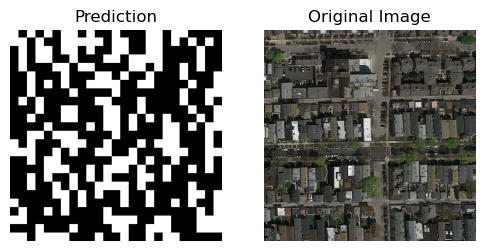

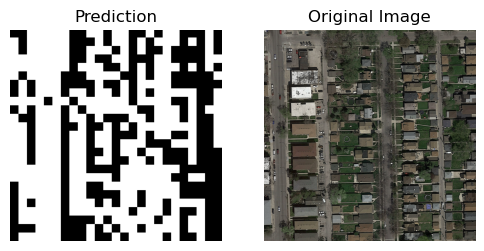

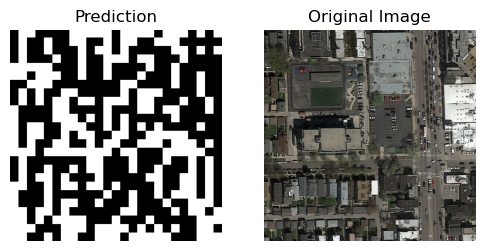

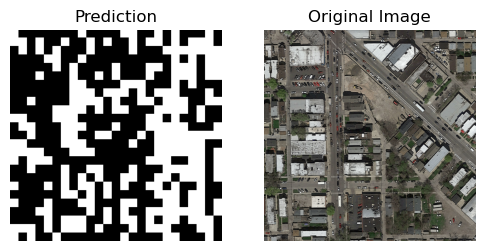

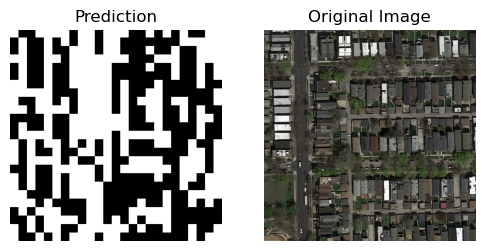

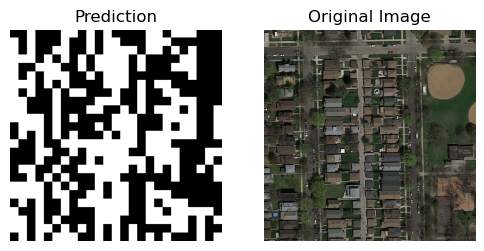

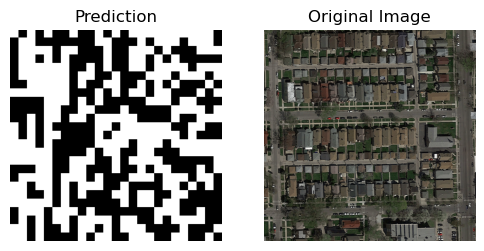

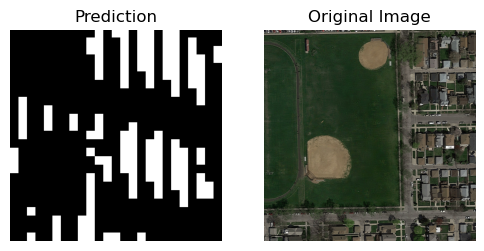

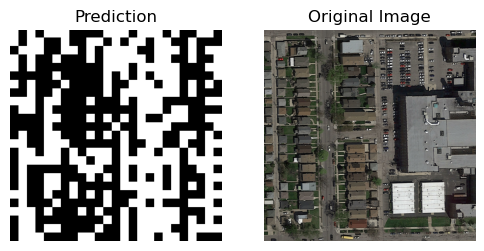

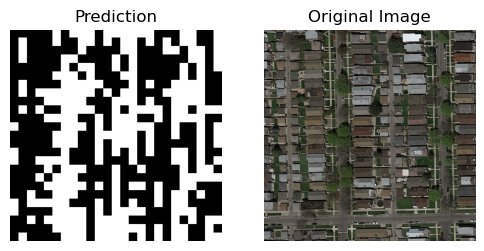

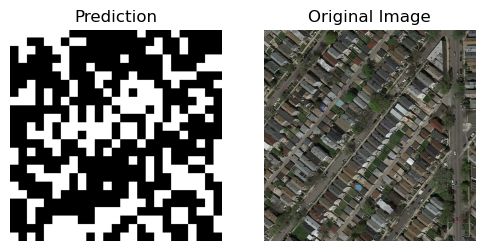

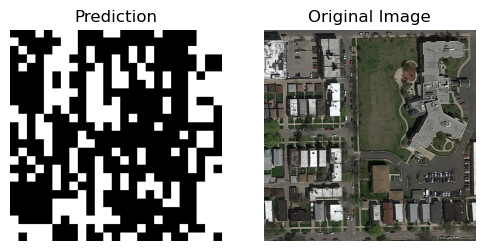

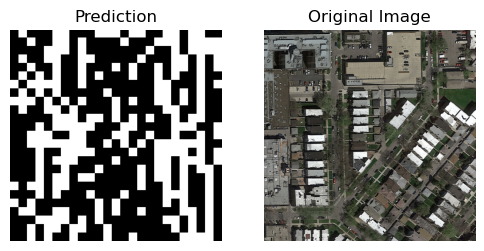

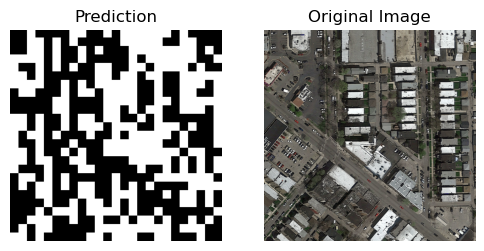

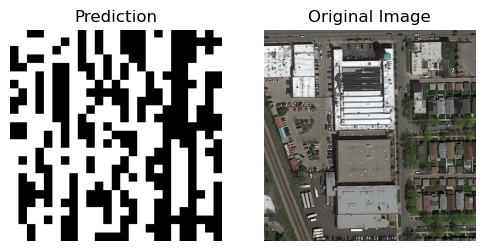

In [312]:



#prediction = logreg.predict(y_t)
#print (y_t.shape)
#print (prediction.shape)
#predicted_ims = [ label_to_img(w, h, patch_size, patch_size, predicted_im) for predicted_im in prediction]

def get_predicted_img (test_imgs,model, patch_size=16): 
    predicted_ims = []
    for i in range(len(test_imgs)):
        img_patches = img_crop(test_imgs[i], patch_size, patch_size)
        y_t= np.asarray([extract_features(patch) for patch in img_patches])
        #print(y_t.shape)
        predictions = (logreg.predict(y_t))
        #print(predictions.shape)
        predicted_ims.append( label_to_img(w, h, patch_size, patch_size, predictions))
    return predicted_ims


predicted_ims = get_predicted_img(test_imgs,logreg, patch_size=16)
print ((test_imgs[0].shape))

for i in range(len(test_imgs)):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
    #cimg = concatenate_images(test_imgs[i], predicted_ims[i])
    
    axes[0].imshow(  predicted_ims[i], cmap='gray')
    axes[0].set_title("Prediction")
    
    #axes[1].imshow(gt_imgs[i], cmap='gray')
    #axes[1].set_title("Prediction")


    axes[1].imshow(test_imgs[i])
    axes[1].set_title("Original Image")

    axes[0].axis("off")
    axes[1].axis("off")
    #axes[2].axis("off")

    plt.show()

In [317]:
from mask_to_submission import masks_to_submission

def getting_sub (prediction):
    output_dir = 'predictions_logistic'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(len (prediction)):
        #pred_mask = (prediction[i] > 0.01).astype(np.uint8)  # Example thresholding, modify as needed
        #pred_image = Image.fromarray(prediction[i] * 255)  # Save the mask as a black and white image
        pred_image = Image.fromarray((prediction[i] * 255).astype(np.uint8), mode='L')
        filename = os.path.join(output_dir, f"prediction_{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    submission_filename = 'lagistic.csv'
    masks_to_submission(submission_filename, *pred_filenames)

getting_sub(predicted_ims)


